# Fuzzy Clustering

The clustering algorithms that we learned so far fall under the category of hard clustering. In a **hard clustering** setting, each data point belongs to one and only one  cluster. In a **fuzzy clustering (aka soft clustering)**, a data point can belong to multiple clusters. The memberships of a point is expressed in terms of probabilities. 

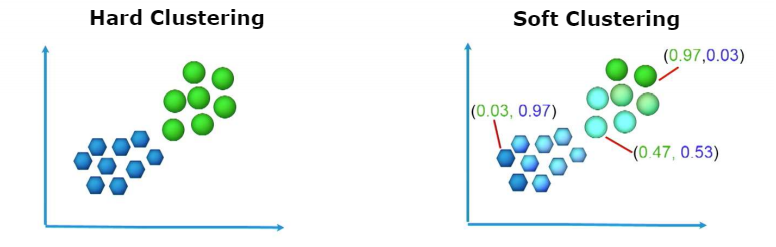
[Figure source](https://towardsdatascience.com/fuzzy-c-means-clustering-is-it-better-than-k-means-clustering-448a0aba1ee7)

In this notebook, we will learn the aplication of **fuzzy c-means** algorithm using synthetic data. We will visualize both the KMeans and Fuzzy C-means Clustering. Later, we will inspect how the membeship of one sample point varies from cluster to cluster.

### Setting up the environment
use **pip install -U scikit-fuzzy** for skyfuzz

In [ ]:
!pip install -U scikit-fuzzy 

In [ ]:
import skfuzzy as fuzz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
%matplotlib inline

### Configure some general styling

In [ ]:
sns.set_style("white")
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.figsize'] = (8,7)
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

### Define three cluster centers

Let's draw three clusters from Gaussian distributions. For simplicity, let's assume there are 2 features. 

In [ ]:
centers = [[4, 2],
           [1, 7],
           [5, 6]]

In [ ]:
sigmas = [[0.8, 0.3],
          [0.3, 0.5],
          [1.1, 0.7]]

### Generate data

In [ ]:
np.random.seed(42)  # Set seed for reproducibility
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)

for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
    xpts = np.hstack((xpts, np.random.standard_normal(200) * xsigma + xmu))
    ypts = np.hstack((ypts, np.random.standard_normal(200) * ysigma + ymu))
    labels = np.hstack((labels, np.ones(200) * i))
    
data=np.transpose(np.vstack((xpts,ypts)))

In [ ]:
xpts.shape

### Visualization the synthetic data

In [ ]:
plt.scatter(data[:,0],data[:,1], c=labels);

Here is we created our test data and plotted them in the figure. With a human eye we can see there there are 3 distinct clusters.

### Apply the KMeans Clustering Technique

In [ ]:
kmeans = KMeans(n_clusters=3)
pred_y = kmeans.fit_predict(data)

### Visualize the Clusters

In [ ]:
for label in range(3):
    plt.plot(xpts[kmeans.labels_ == label], ypts[kmeans.labels_ == label], '.')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.title("Visualization of the Clusters (Kmeans)")
plt.show()

### Resape the data for c-means

In [ ]:
# Reshape the data
data=np.vstack((xpts,ypts))
print("The size of data for fuzzy cmeans is", np.shape(data))

### Apply c-means

In [ ]:
ncenters=3 # number of centers; later we will see how to choose this number

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data, ncenters, 2, error=0.005, maxiter=3000, init=None)

Here **u** is the partition matrix. Each element of this matrix can be denoted as $$W{i,j}$$where i=1,2,...., Total Number of Clusters and j=1,2,.....,Total Number of Sample Points. $$W{i,j}$$ indicates the membership of j^th sample in i^th cluster.

In [ ]:
u.shape

Let's inspect the cluster assignment of the 10th point.

In [ ]:
u[:,10]

In [ ]:
u[:,10].sum()  # sum should be 1 as each element is a probability

Here ith element is a probability of belonging to the ith cluster. We can see the 10th point most likely belongs to cluster 0. 

### Visualize the clusters

In [ ]:
# Plot assigned clusters, for each data point in training set
cluster_membership = np.argmax(u, axis=0)
for j in range(ncenters):
    plt.plot(data[0,:][cluster_membership == j],data[1,:][cluster_membership == j], 
             '.', color=colors[j])

# Mark the center of each fuzzy cluster
for pt in cntr:
    plt.plot(pt[0], pt[1], 'rs', markersize=12)

plt.title("Visualization of the clusters (c-means)")

In our configured general styling, the order of colors were blue, orange, green and so on. Based on it, we can say blue is cluster #1 , orange is cluster#2, and green is cluster#3. 

### Inspecting the strongest and weakest member of Cluster #1

In [ ]:
weak = u[0,:].min()
strong = u[0,:].max()
weakIdx = u[0,:].argmin()
strongIdx = u[0,:].argmax()

print(f"{weakIdx}-th sample is the weakest member and the probability is {weak}")
print(f"{strongIdx}-th sample is the strongest member and the probability is {strong}")

### Visualizing the weakest and strongest member

In [ ]:
for j in range(ncenters):
    plt.plot(data[0,:][cluster_membership == j],data[1,:][cluster_membership == j], 
             '.', color=colors[j])
    
# Mark the center of each fuzzy cluster
for pt in cntr:
    plt.plot(pt[0], pt[1], 'rs', markersize=12)
    
plt.plot(data[0,weakIdx],data[1,weakIdx],'^k:', markersize=12)
plt.plot(data[0,strongIdx],data[1,strongIdx],'^c:', markersize=12)

plt.title("Visualization of the clusters#1 and membership")

The cyan triangle is the strongest member and the black triangle is the weakest member of the cluster#1 (blue). The cluster probalities of point 312 and 512 are as follows: 

In [ ]:
print(u[:, 312])

In [ ]:
print(u[:, 512])

### Choosing the right number of clusters

We can check the goodness of the clusters based on the fuzzy partition coefficient (FPC). We will compare the FPC values for a different number of clusters and pick the one with the highest FPC value. 

In [ ]:
maxCenters= 5
FPCs=[]
for ncenters in range(2, maxCenters + 1):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data,  ncenters, 2, error=0.005, maxiter=1000, init=None)
    FPCs.append(fpc)

In [ ]:
plt.plot(range(2, maxCenters + 1),FPCs)
plt.xlabel("number of clusters")
plt.ylabel("fuzzy partition coefficient")

We observe that fuzzy clustering with 3 clusters would give us the best FPC.